In [1]:
import numpy as np
from skimage import io, exposure
from scipy.ndimage import gaussian_filter, binary_erosion, binary_dilation
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, sobel

In [2]:
output_file = "/Users/anthonydibenedetto/Desktop/VFP_MEETING/Tomo88/MASK_FULL_88.tiff"


In [3]:
input_file = "/Users/anthonydibenedetto/Desktop/VFP_MEETING/Tomo88/tomographic_image_88.tiff"
data = io.imread(input_file)

# Print data shape
print(f"Loaded data shape: {data.shape}")

Loaded data shape: (200, 2448, 2448)


In [4]:
def show_slices_together(data, data_corrected, data_smoothed, segmented, slice_index):
    print(f"Slice index: {slice_index}")
    print(f"Data shape: {data.shape}")
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(data[slice_index, :, :], cmap='gray', aspect='auto')
    axes[0].set_title('Original Data')
    axes[1].imshow(data_corrected[slice_index, :, :], cmap='gray', aspect='auto')
    axes[1].set_title('Corrected Data')
    axes[2].imshow(data_smoothed[slice_index, :, :], cmap='gray', aspect='auto')
    axes[2].set_title('Smoothed Data')
    axes[3].imshow(segmented[slice_index, :, :], cmap='gray', aspect='auto')
    axes[3].set_title('Segmented Data')
    plt.show()


In [5]:
# Preprocessing step (example: bias correction, could be anything)
data_corrected = exposure.equalize_adapthist(data) # Placeholder for actual correction logic

# Smoothing the data
data_smoothed = gaussian_filter(data_corrected, sigma=1)



In [6]:
# Print the range of the smoothed data
print(f"Data smoothed range: min={data_smoothed.min()}, max={data_smoothed.max()}")

Data smoothed range: min=0.029404253981129967, max=0.9303644533662823


In [7]:
# Segmentation using Otsu's method
threshold = threshold_otsu(data_corrected)
segmented = data_corrected > threshold

In [8]:
# Function to round the slice values to 0 or 1
def round_slice(slice):
    return np.round(slice).astype(np.uint8)

# Function to flip the slice if the background is not black
def flip_if_needed(slice, slice_number):
    # Round the slice to ensure binary values
    slice = round_slice(slice)
    
    # Calculate the counts of black and white pixels
    black_count = np.sum(slice == 0)
    white_count = np.sum(slice == 1)
    total_count = slice.size
    
    # Calculate the ratios
    black_ratio = black_count / total_count
    white_ratio = white_count / total_count
    
    # Determine if the slice needs to be inverted
    invert = white_ratio > black_ratio
    print(f"Slice {slice_number} black ratio: {black_ratio}, white ratio: {white_ratio}, inverted: {invert}")  # Debugging line
    
    # Flip if the white ratio is higher than the black ratio
    if invert:
        slice = 1 - slice  # Manually invert the slice
    return slice

# Function to keep a 415x415 region in the center unchanged and make the surrounding black
def apply_center_mask(slice, center_size=1800):
    height, width = slice.shape
    mask = np.zeros_like(slice, dtype=np.uint8)
    
    # Calculate center box coordinates
    start_x = (width - center_size) // 2
    end_x = start_x + center_size
    start_y = (height - center_size) // 2
    end_y = start_y + center_size
    
    # Apply the mask
    mask[start_y:end_y, start_x:end_x] = slice[start_y:end_y, start_x:end_x]
    
    return mask

# Process each slice to ensure the correct orientation and apply the center mask
segmented_corrected = np.zeros_like(segmented, dtype=np.uint8)
for i in range(segmented.shape[0]):
    slice = segmented[i, :, :]
    corrected_slice = flip_if_needed(slice, i)
    masked_slice = apply_center_mask(corrected_slice)
    segmented_corrected[i, :, :] = masked_slice.astype(np.uint8)

Slice 0 black ratio: 0.9581429351424666, white ratio: 0.041857064857533426, inverted: False
Slice 1 black ratio: 0.9580705137447135, white ratio: 0.041929486255286426, inverted: False
Slice 2 black ratio: 0.9579119876436414, white ratio: 0.042088012356358666, inverted: False
Slice 3 black ratio: 0.9576485005767013, white ratio: 0.04235149942329873, inverted: False
Slice 4 black ratio: 0.9574045372506301, white ratio: 0.0425954627493699, inverted: False
Slice 5 black ratio: 0.9571008346148917, white ratio: 0.04289916538510829, inverted: False
Slice 6 black ratio: 0.9568877421611346, white ratio: 0.043112257838865395, inverted: False
Slice 7 black ratio: 0.9567969651095732, white ratio: 0.04320303489042676, inverted: False
Slice 8 black ratio: 0.9568889102481951, white ratio: 0.04311108975180486, inverted: False
Slice 9 black ratio: 0.9571427188794908, white ratio: 0.042857281120509204, inverted: False
Slice 10 black ratio: 0.9574267309047803, white ratio: 0.04257326909521979, inverted: 

100
Slice index: 100
Data shape: (200, 2448, 2448)


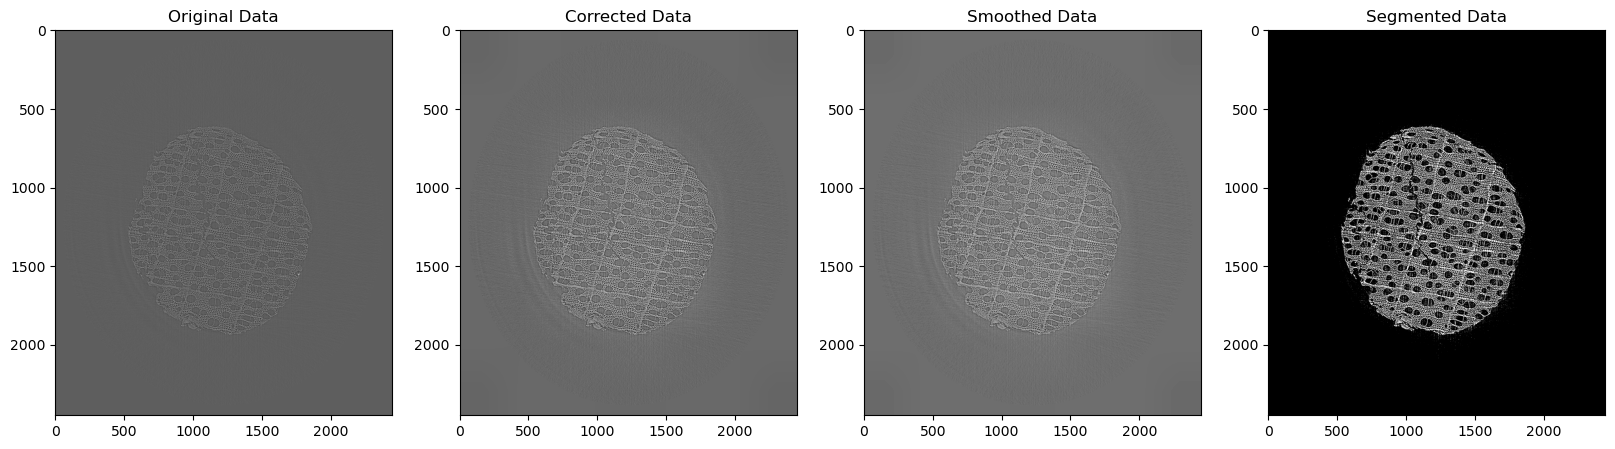

In [9]:
slice_index = data.shape[0] -100# Show the middle slice
print(slice_index)

# Show all stages in one plot
show_slices_together(data, data_corrected, data_smoothed, segmented_corrected, slice_index)

In [10]:
# Convert segmented image to uint8 with appropriate scaling
segmented_uint8 = (segmented_corrected * 255).astype(np.uint8)

# Save the segmented 3D image as a TIFF file
io.imsave(output_file, segmented_uint8)

print(f"Segmented 3D image saved to {output_file}")

Segmented 3D image saved to /Users/anthonydibenedetto/Desktop/VFP_MEETING/Tomo88/MASK_FULL_88.tiff
